
Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Accessing CANSIM NDM vectors from Statistics Canada

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as

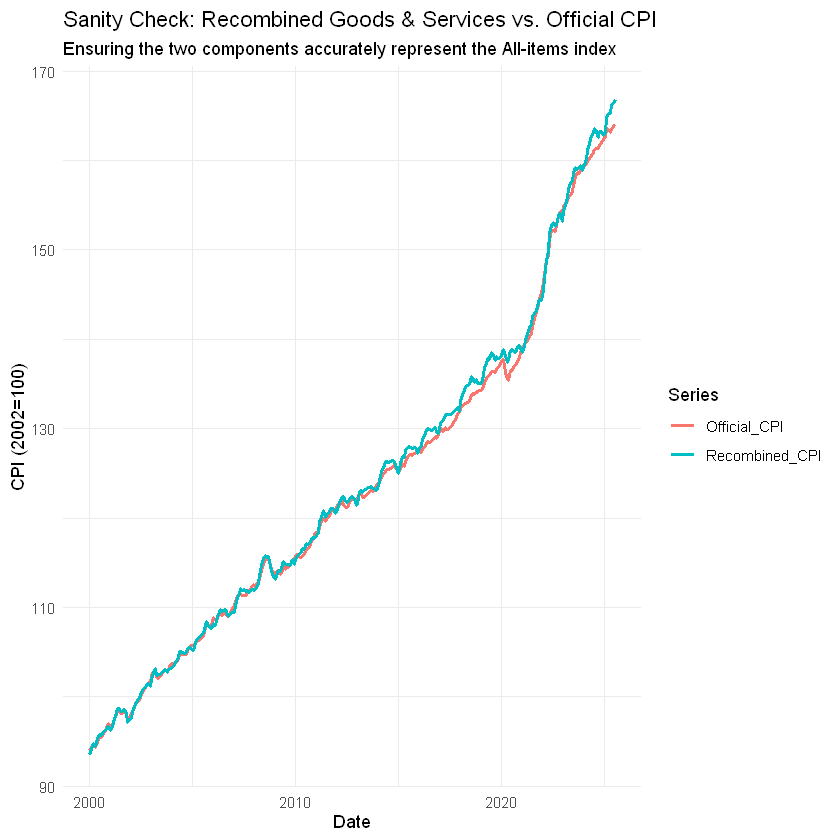

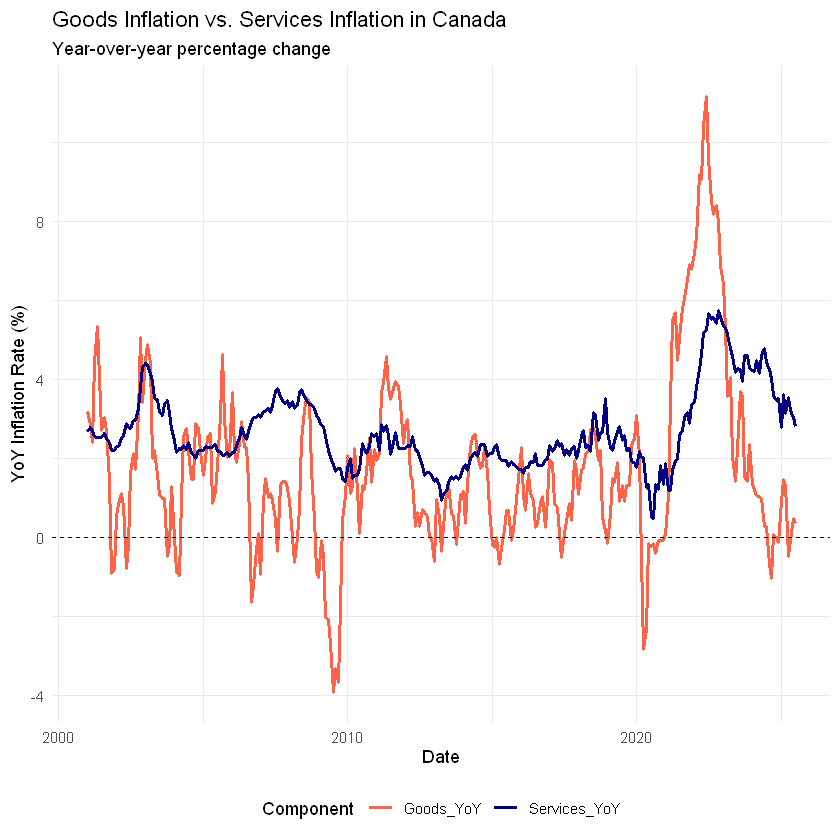

In [1]:
# --- 0. LOAD LIBRARIES ---
# Ensure all necessary packages are loaded
library(cansim)
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)


# --- 1. DEFINE VECTORS FOR GOODS AND SERVICES ---

# Vectors for the CPI basket weights
cpi_weight_vectors <- c(
  Goods = "v91859278",
  Services = "v91873252"
)

# Vectors for the CPI index levels
cpi_vectors <- c(
  Goods = "v41691222",
  Services = "v41691230"
)


# --- 2. DOWNLOAD AND PROCESS DATA ---

# --- CPI Data (Monthly) ---
# Download and combine the monthly CPI data for Goods and Services
cpi_data_long <- purrr::map2_df(
  cpi_vectors,
  names(cpi_vectors),
  ~ get_cansim_vector(.x, start_time = "2000-01-01") %>% mutate(Component = .y)
)

# Convert to wide format for easy calculations
cpi_data_wide <- cpi_data_long %>%
  select(Date, Component, VALUE) %>%
  pivot_wider(names_from = Component, values_from = VALUE) %>%
  arrange(Date)


# --- Weight Data (Annual/Biennial) ---
# Download and combine the weight data
weights_data_long <- purrr::map2_df(
  cpi_weight_vectors,
  names(cpi_weight_vectors),
  ~ get_cansim_vector(.x, start_time = "1996-01-01") %>% mutate(Component = .y)
)

# Process weights: create a complete monthly series, fill forward, and lag by 1 year
monthly_weights_df <- weights_data_long %>%
  select(Date, Component, VALUE) %>%
  pivot_wider(names_from = Component, values_from = VALUE) %>%
  # Create a row for every month
  complete(Date = seq.Date(min(Date), today(), by = "month")) %>%
  # Fill the empty months with the last known weight
  fill(everything(), .direction = "down") %>%
  # Lag weights to align the basket measurement period with the CPI calculation period
  mutate(across(-Date, ~lag(.x, 12))) %>%
  # Remove any initial rows that are now NA
  filter(!is.na(Goods))


# --- 3. SANITY CHECK: RECOMBINE AND COMPARE TO TOTAL CPI ---

# Vector for the official "All-items CPI"
total_cpi_vector <- "v41690914"
official_cpi_df <- get_cansim_vector(total_cpi_vector, start_time = "2000-01-01") %>%
  select(Date, Official_CPI = VALUE)

# Join CPI data with the prepared monthly weights
recombined_df <- cpi_data_wide %>%
  left_join(monthly_weights_df, by = "Date", suffix = c("_CPI", "_Weight")) %>%
  filter(!is.na(Goods_Weight)) %>%
  # Recombine using the weights
  mutate(
    Total_Weight = Goods_Weight + Services_Weight,
    Recombined_CPI = (Goods_CPI * Goods_Weight + Services_CPI * Services_Weight) / Total_Weight
  ) %>%
  # Join with the official CPI for comparison
  left_join(official_cpi_df, by = "Date")


# --- Plot the Sanity Check ---
# Tidy the data for plotting
sanity_check_plot_data <- recombined_df %>%
  select(Date, Recombined_CPI, Official_CPI) %>%
  pivot_longer(cols = -Date, names_to = "Series", values_to = "Value")

# Generate the plot
sanity_check_plot <- ggplot(sanity_check_plot_data, aes(x = Date, y = Value, color = Series)) +
  geom_line(linewidth = 1) +
  labs(
    title = "Sanity Check: Recombined Goods & Services vs. Official CPI",
    subtitle = "Ensuring the two components accurately represent the All-items index",
    y = "CPI (2002=100)",
    x = "Date"
  ) +
  theme_minimal()

# Display the sanity check plot
print(sanity_check_plot)


# --- 4. CALCULATE AND PLOT YOY INFLATION FOR GOODS VS. SERVICES ---

# Calculate the YoY % change directly from the wide CPI data
inflation_goods_services_df <- cpi_data_wide %>%
  mutate(
    Goods_YoY = ((Goods / lag(Goods, 12)) - 1) * 100,
    Services_YoY = ((Services / lag(Services, 12)) - 1) * 100
  ) %>%
  select(Date, ends_with("_YoY")) %>%
  filter(!is.na(Goods_YoY))

# Tidy the data for the final plot
inflation_plot_data <- inflation_goods_services_df %>%
  pivot_longer(cols = -Date, names_to = "Component", values_to = "YoY_Change")


# --- Plot the Final Inflation Rates ---
final_plot <- ggplot(inflation_plot_data, aes(x = Date, y = YoY_Change, color = Component)) +
  geom_line(linewidth = 1) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  labs(
    title = "Goods Inflation vs. Services Inflation in Canada",
    subtitle = "Year-over-year percentage change",
    y = "YoY Inflation Rate (%)",
    x = "Date",
    color = "Component"
  ) +
  scale_color_manual(values = c("Goods_YoY" = "tomato", "Services_YoY" = "navy")) +
  theme_minimal() +
  theme(legend.position = "bottom")

# Display the final plot
print(final_plot)

In [2]:
inflation_goods_services_df

Date,Goods_YoY,Services_YoY
<date>,<dbl>,<dbl>
2001-01-01,3.1914894,2.685285
2001-02-01,2.8511088,2.780749
2001-03-01,2.4008351,2.668090
2001-04-01,4.4257113,2.550478
2001-05-01,5.3515215,2.539683
2001-06-01,4.0540541,2.528978
2001-07-01,2.6998962,2.515723
2001-08-01,3.0239833,2.617801
2001-09-01,2.6915114,2.510460


In [3]:
library(tidyverse)
library(cansim)
library(readr)
library(vroom)
library(lubridate)
library(tseries)
library(strucchange)
library(purrr) 
library(vars)
library(fredr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ purrr   1.1.0     ✔ tibble  3.3.0
✔ readr   2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'vroom'


The following objects are masked from 'package:readr':

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_names,
    date_names_lang, date_names_langs, default_locale, fwf_cols,
    fwf_empty, fwf_positions, fwf_widths, locale, output_column,
    problems, spec


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo

In [4]:
fredr_set_key('b43b23bac4c602369428a1a4316f23d4')

In [5]:
# --- Statistics Canada Data ---
cpi_vec <- get_cansim_vector_for_latest_periods("v108785715", periods = 500) # Monthly CPI, pct change
unemp_vec <- get_cansim_vector_for_latest_periods('v2062815', periods = 500) # Unemployment Rate
fcpi_vec <- get_cansim_vector_for_latest_periods('v52673496', periods = 500) # Fisher Commodity Price Index
gdp_vec <- get_cansim_vector_for_latest_periods("v65201210", periods = 300) # Monthly GDP
monthly_conventional_bond <- get_cansim_vector_for_latest_periods('v122543', periods = 500) # Conventional Bond Yield
monthly_real_return_bond <- get_cansim_vector_for_latest_periods('v122553', periods = 500) # Real Return Bond Yield
# --- Bank of Canada Policy Interest Rate ---
policy_rate_daily_vec <- get_cansim_vector("v39050", start_time = "2000-01-01")
ippi_vec <- get_cansim_vector_for_latest_periods("v1249303102", periods = 500)

# --- FRED Data ---
wti_price_monthly <- fredr(series_id = "MCOILWTICO", observation_start = as.Date("1990-01-01")) # WTI Oil Price
exc_rate <- fredr(series_id = "DEXCAUS", observation_start = as.Date("1990-01-01"), frequency = "m", units = "chg") # US-CAN Exchange Rate
trade_commodities <- fredr(series_id = "XTNTVA01CAM664S", observation_start = as.Date("1990-01-01"), frequency = "m", units = "chg") # Trade in Goods

# --- Local CSV Files ---
all_tariff_data <- read_csv("C:/Users/Irene/governorschallenge/DataWeb-Query-Export.csv")
tpu_data <- read_csv("Categorical_EPU_Data.csv")
supply_chain_pressure <- read_csv("C:/Users/Irene/governorschallenge/gscpi_data.csv")
lfs_micro <- read_csv('C:/Users/Irene/governorschallenge/INDINF_WAGES_MONTHLY.csv', skip = 20)

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Rows: 616 Columns: 4
── Column specification ─────────────────────

In [6]:
### SET A GLOBAL START DATE FOR FILTERING ###
start_date <- "1990-01-01"

### PROCESS EACH DATAFRAME ###

# --- Global Supply Chain Pressure Index ---
supply_chain_pressure_monthly <- supply_chain_pressure |>
  dplyr::select(Date, GSCPI) |>
  mutate(Date = dmy(Date)) |>
  drop_na() |>
  mutate(
    month = floor_date(Date, "month"),
    delta_supply_chain = GSCPI - lag(GSCPI, 1) # Simple difference is better for this index
  ) |>
  dplyr::select(month, delta_supply_chain) |>
  filter(month >= start_date)

# --- Policy Interest Rate (Level) ---
policy_rate_monthly <- policy_rate_daily_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(month = floor_date(Date, "month")) |>
  group_by(month) |>
  summarise(
    policy_rate = mean(VALUE, na.rm = TRUE) # Calculate the monthly average
  ) |>
  ungroup()

# --- GDP ---
gdp_monthly <- gdp_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(
    month = floor_date(Date, "month"),
    delta_gdp = (log(VALUE) - log(lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_gdp) |>
  filter(month >= start_date)

# --- Break-even Inflation Rate ---
bond_monthly <- monthly_conventional_bond |>
  dplyr::select(Date, VALUE) |>
  inner_join(dplyr::select(monthly_real_return_bond, Date, VALUE), by = "Date", suffix = c("_conv", "_real")) |>
  mutate(
    break_even_rate = VALUE_conv - VALUE_real,
    month = floor_date(Date, "month"),
    delta_bond = break_even_rate - lag(break_even_rate, 1) # Simple difference
  ) |>
  dplyr::select(month, delta_bond) |>
  filter(month >= start_date)

# --- Trade Policy Uncertainty ---
trade_unc_monthly <- tpu_data |>
  mutate(Date = ymd(paste(Year, Month, "01", sep = "-"))) |>
  rename(VALUE = `9. Trade policy`) |>
  dplyr::select(Date, VALUE) |>
  mutate(
    month = floor_date(Date, "month"),
    delta_trade_unc = (log(VALUE) - log(lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_trade_unc) |>
  filter(month >= start_date)

# --- CPI (already a % change, so just rename) ---
cpi_monthly <- cpi_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(month = Date, delta_cpi = VALUE) |>
  dplyr::select(month, delta_cpi) |>
  filter(month >= start_date)

# --- Fisher Commodity Price Index ---
fcpi_monthly <- fcpi_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(
    month = Date,
    delta_fcpi = (log(VALUE) - log(lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_fcpi) |>
  filter(month >= start_date)

# --- WTI Oil Price ---
oil_monthly <- wti_price_monthly |>
  dplyr::select(date, value) |>
  mutate(
    month = floor_date(date, "month"),
    delta_oil = (log(value) - log(lag(value, 1))) * 100
  ) |>
  dplyr::select(month, delta_oil) |>
  filter(month >= start_date)

# --- US-Canada Trade in Goods (already a % change) ---
trade_commodities_monthly <- trade_commodities |>
  dplyr::select(date, value) |>
  mutate(month = date, trade_us_canada = value) |>
  dplyr::select(month, trade_us_canada) |>
  filter(month >= start_date)

# --- Exchange Rate (already a % change) ---
exc_monthly <- exc_rate |>
  dplyr::select(date, value) |>
  rename(month = date, delta_exc = value) |>
  dplyr::select(month, delta_exc) |>
  filter(month >= start_date)

# --- Labour Force Survey Microdata (Wages) ---
lfs_micro_monthly <- lfs_micro |>
  dplyr::select(date, INDINF_LFSMICRO_M) |>
  rename(Date = date, VALUE = INDINF_LFSMICRO_M) |>
  mutate(
    Date = mdy(Date),
    month = floor_date(Date, "month"),
    delta_lfs_wages = (log(VALUE) - log(lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_lfs_wages) |>
  filter(month >= start_date)

# --- Unemployment Rate (use the rate directly, not the change) ---
unemp_monthly <- unemp_vec |>
  dplyr::select(Date, VALUE) |>
  mutate(
    month = floor_date(Date, "month"),
    unemp_rate = VALUE
  ) |>
  dplyr::select(month, unemp_rate) |>
  filter(month >= start_date)

# --- Tariff Rate Calculation (CORRECTED BLOCK) ---
# 1. Create a clean dataframe for import charges
general_import_charges <- all_tariff_data |>
  filter(`Data Type` == "General Import Charges") |>
  # CORRECTED: Select the 'General Import Charges' column
  dplyr::select(Year, Month, `General Import Charges`) |>
  rename(VALUE_charges = `General Import Charges`)

# 2. Create a clean dataframe for customs value
general_customs_value <- all_tariff_data |>
  filter(`Data Type` == "General Customs Value") |>
  dplyr::select(Year, Month, `General Customs Value`) |>
  rename(VALUE_value = `General Customs Value`)

# 3. Join them and calculate the rate
tariff_rate_df <- inner_join(
  general_import_charges,
  general_customs_value,
  by = c("Year", "Month")
) |>
  mutate(
    month = ymd(paste(Year, Month, "01", sep = "-")),
    tarrif_rate = (as.numeric(VALUE_charges) / as.numeric(VALUE_value)) * 100
  ) |>
  dplyr::select(month, tariff_rate) |>
  filter(month >= start_date)

Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Date = ymd(paste(Year, Month, "01", sep = "-"))`.
Caused by warning:
!  1 failed to parse."


ERROR: [1m[33mError[39m in `dplyr::select()`:[22m
[33m![39m Can't select columns that don't exist.
[31m✖[39m Column `General Import Charges` doesn't exist.


In [ ]:
### COMBINE ALL PROCESSED DATAFRAMES INTO A SINGLE MASTER DATAFRAME ###

# --- Function to join a list of dataframes ---
combine_processed_dfs <- function(...) {
  list_of_dfs <- list(...)
  # Use purrr::reduce for a clean, sequential inner_join
  combined_df <- reduce(list_of_dfs, inner_join, by = "month")
  return(combined_df)
}

# --- Use the function to create the final dataframe ---
final_monthly_df <- combine_processed_dfs(
  cpi_all_monthly,
  supply_chain_pressure_monthly,
  gdp_monthly,
  bond_monthly,
  oil_monthly,
  trade_unc_monthly,
  cpi_monthly,
  fcpi_monthly,
  trade_commodities_monthly,
  lfs_micro_monthly,
  unemp_monthly,
  exc_monthly,
  policy_rate_monthly,
  tarrif_rate_df
) |>
  drop_na() |> # Remove any rows with NAs that result from calculations/joins
  arrange(month) |>
  dplyr::select(!Date)

# --- Inspect the final, combined dataframe ---
glimpse(final_monthly_df)
head(final_monthly_df)
tail(final_monthly_df)

Rows: 294
Columns: 16
$ Goods_YoY          <dbl> 3.1914894, 2.8511088, 2.4008351, 4.4257113, 5.35152…
$ Services_YoY       <dbl> 2.685285, 2.780749, 2.668090, 2.550478, 2.539683, 2…
$ month              <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-01, 20…
$ delta_supply_chain <dbl> 0.00, 0.15, 0.20, -0.37, -0.13, 0.39, -0.11, 0.04, …
$ delta_gdp          <dbl> 0.007181486, -0.031518707, 0.058706070, -0.08967659…
$ delta_bond         <dbl> 1.000000e-01, -6.000000e-02, -1.000000e-02, 9.00000…
$ delta_oil          <dbl> 3.96398615, 0.06756757, -8.30586210, 0.87687811, 4.…
$ delta_trade_unc    <dbl> -7.255945, -75.509001, -31.636202, 96.397195, -121.…
$ delta_cpi          <dbl> 2.2, 2.2, 2.2, 2.4, 2.4, 2.4, 2.5, 2.4, 2.3, 2.2, 1…
$ delta_fcpi         <dbl> -3.4733370, -9.5590724, -2.4684897, 2.1593704, 0.37…
$ trade_us_canada    <dbl> 2020000000, -1716600000, -393800000, -204200000, 12…
$ delta_lfs_wages    <dbl> 0.000000, 16.430305, 2.985296, -2.985296, 8.701138,…
$ unemp_rate      

Goods_YoY,Services_YoY,month,delta_supply_chain,delta_gdp,delta_bond,delta_oil,delta_trade_unc,delta_cpi,delta_fcpi,trade_us_canada,delta_lfs_wages,unemp_rate,delta_exc,policy_rate,Approximate_Rate
<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.191489,2.685285,2001-01-01,0.00,0.007181486,0.10,3.96398615,-7.255945,2.2,-3.4733370,2020000000,0.000000,6.9,-0.0186750000,5.663636,1.451342
2.851109,2.780749,2001-02-01,0.15,-0.031518707,-0.06,0.06756757,-75.509001,2.2,-9.5590724,-1716600000,16.430305,7.0,0.0183631579,5.492500,1.418153
2.400835,2.668090,2001-03-01,0.20,0.058706070,-0.01,-8.30586210,-31.636202,2.2,-2.4684897,-393800000,2.985296,7.1,0.0371777512,5.061900,1.369565
4.425711,2.550478,2001-04-01,-0.37,-0.089676598,0.09,0.87687811,96.397195,2.4,2.1593704,-204200000,-2.985296,7.1,-0.0009742424,4.865280,1.512005
5.351522,2.539683,2001-05-01,-0.13,0.425145224,0.33,4.06328169,-121.759529,2.4,0.3708286,125600000,8.701138,7.0,-0.0167166667,4.707777,1.436815
4.054054,2.528978,2001-06-01,0.39,-0.084161488,-0.18,-3.66393464,68.908831,2.4,-5.7448763,-1665400000,-8.701138,7.2,-0.0165119048,4.492319,1.379190


Goods_YoY,Services_YoY,month,delta_supply_chain,delta_gdp,delta_bond,delta_oil,delta_trade_unc,delta_cpi,delta_fcpi,trade_us_canada,delta_lfs_wages,unemp_rate,delta_exc,policy_rate,Approximate_Rate
<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.90845563,2.772964,2025-01-01,0.09,0.40814644,-0.02,7.709836,26.87600,2.7,4.4307975,2381000000,-2.817088,6.6,0.014157143,3.221818,2.293447
1.46341463,3.624856,2025-02-01,0.18,-0.21048486,-0.08,-5.718948,40.36611,2.9,-0.7621504,-4130700000,8.223810,6.6,-0.008998747,2.993416,2.476286
1.31761442,3.141062,2025-03-01,-0.18,0.19295409,-0.02,-4.708604,82.77030,2.8,0.2864875,-1686600000,-5.406722,6.7,0.005713033,2.840695,2.517684
-0.48143054,3.532764,2025-04-01,-0.09,-0.14040052,-0.16,-7.136127,29.68796,3.1,-3.7569185,-4322600000,-2.817088,6.9,-0.037435281,2.739815,2.745029
-0.06872852,3.216704,2025-05-01,0.54,-0.09626004,0.11,-2.179706,-31.94719,3.0,-0.3636969,772800000,-8.961216,7.0,-0.011445671,2.742352,2.658700
0.48342541,3.040541,2025-06-01,-0.13,-0.07898231,0.02,9.213202,-48.94528,3.0,5.2584279,-1773400000,-3.174870,6.9,-0.019865238,2.744125,2.604812


In [ ]:
variables_to_test <- setdiff(names(final_monthly_df), "month")

# Loop through each variable name
for (var in variables_to_test) {
  
  # Run the ADF test on the column
  adf_result <- adf.test(final_monthly_df[[var]], alternative = "stationary")
  
  # Print a formatted summary of the results
  cat("--- ADF Test for:", var, "---\n")
  cat("Dickey-Fuller Statistic:", round(adf_result$statistic, 3), "\n")
  cat("P-value:", round(adf_result$p.value, 4), "\n")
  
  # Interpret the result based on the p-value
  if (adf_result$p.value < 0.1) {
    cat("Result: The series is Stationary (p < 0.05)\n\n")
  } else {
    cat("Result: The series is Non-Stationary (p >= 0.05)\n\n")
  }
}

--- ADF Test for: Goods_YoY ---
Dickey-Fuller Statistic: -3.647 
P-value: 0.029 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: Services_YoY ---
Dickey-Fuller Statistic: -2.75 
P-value: 0.2604 
Result: The series is Non-Stationary (p >= 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_supply_chain ---
Dickey-Fuller Statistic: -8.005 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_gdp ---
Dickey-Fuller Statistic: -7.754 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_bond ---
Dickey-Fuller Statistic: -7.64 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_oil ---
Dickey-Fuller Statistic: -6.883 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_trade_unc ---
Dickey-Fuller Statistic: -7.381 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: delta_cpi ---
Dickey-Fuller Statistic: -3.241 
P-value: 0.0814 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_fcpi ---
Dickey-Fuller Statistic: -6.716 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: trade_us_canada ---
Dickey-Fuller Statistic: -8.31 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_lfs_wages ---
Dickey-Fuller Statistic: -7.071 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: unemp_rate ---
Dickey-Fuller Statistic: -3.406 
P-value: 0.0537 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_exc ---
Dickey-Fuller Statistic: -6.656 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: policy_rate ---
Dickey-Fuller Statistic: -2.685 
P-value: 0.2877 
Result: The series is Non-Stationary (p >= 0.05)

--- ADF Test for: Approximate_Rate ---
Dickey-Fuller Statistic: -2.816 
P-value: 0.2325 
Result: The series is Non-Stationary (p >= 0.05)



In [ ]:
df_for_lags_goods <- final_monthly_df|>
dplyr::select(Goods_YoY, delta_supply_chain ,delta_gdp ,delta_fcpi ,delta_bond  ,delta_exc , tariff_rate)
lag_selection <- VARselect(df_for_lags_goods, lag.max = 40, type = "const")

print(lag_selection$selection)

Warning message in log(sigma.det):
"NaNs produced"
Warning message in log(sigma.det):
"NaNs produced"
Warning message in log(sigma.det):
"NaNs produced"


AIC(n)  HQ(n)  SC(n) FPE(n) 
    32     32     32     31 


In [ ]:
var_data_goods <- final_monthly_df |>
dplyr::select(Goods_YoY, delta_supply_chain ,delta_gdp ,delta_fcpi ,delta_bond  ,delta_exc , policy_rate, tariff_rate)|>
 ts(start = c(2001, 1), frequency = 12)

In [ ]:

var_model_12 <- VAR(var_data_goods, p = 12, type = "const")

summary_12 <- summary(var_model_12)

print(summary_12$varresult$Goods_YoY)


Call:
lm(formula = y ~ -1 + ., data = datamat)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.70702 -0.39115  0.02386  0.41332  1.42044 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
Goods_YoY.l1            0.764109   0.081323   9.396  < 2e-16 ***
delta_supply_chain.l1  -0.217083   0.154984  -1.401  0.16298    
delta_gdp.l1           -0.081136   0.084581  -0.959  0.33867    
delta_fcpi.l1           0.054306   0.013172   4.123 5.65e-05 ***
delta_bond.l1           0.713094   0.392494   1.817  0.07086 .  
delta_exc.l1            5.275646   2.985536   1.767  0.07887 .  
policy_rate.l1          0.663378   0.670174   0.990  0.32354    
Approximate_Rate.l1    -0.317563   0.441049  -0.720  0.47242    
Goods_YoY.l2           -0.100457   0.100012  -1.004  0.31647    
delta_supply_chain.l2   0.171441   0.159205   1.077  0.28295    
delta_gdp.l2           -0.028766   0.088465  -0.325  0.74542    
delta_fcpi.l2           0.013673   0.013669   1.000  

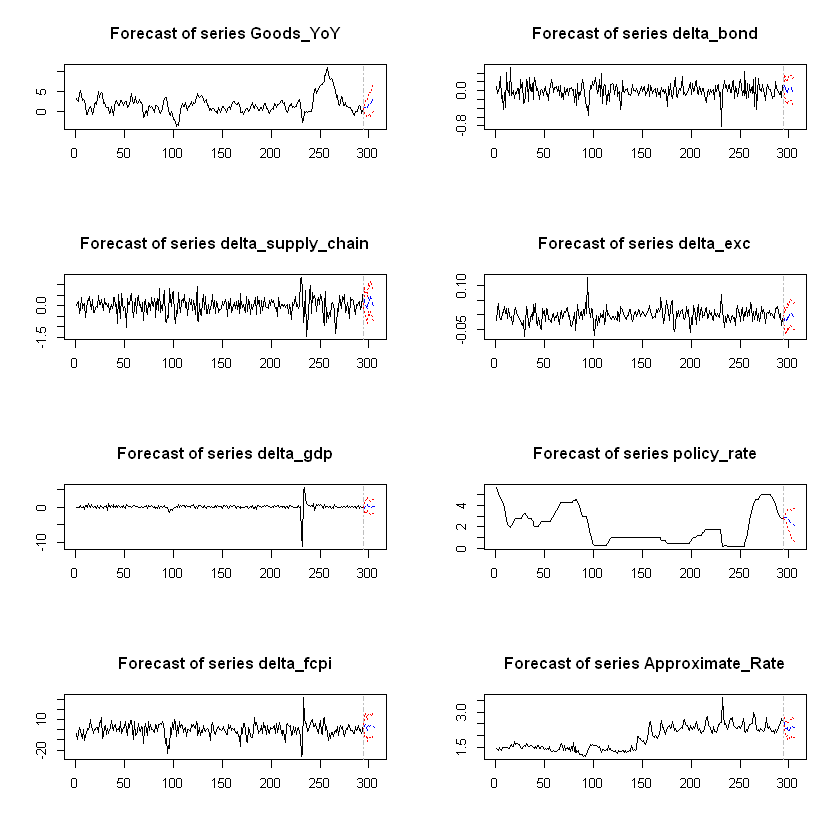

In [ ]:

forecast_results <- predict(var_model_12, n.ahead = 12, ci = 0.90)

plot(forecast_results)

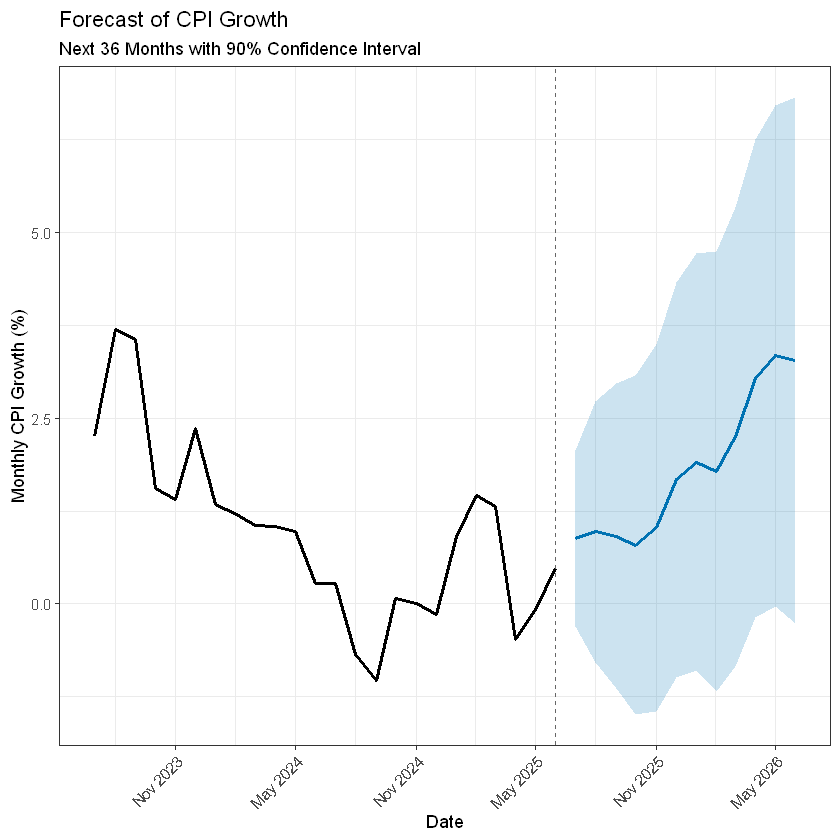

In [ ]:
library(ggplot2)
library(dplyr)
library(lubridate)

# Assuming 'var_model_12' and 'final_monthly_df' are in your environment

# --- 1. Generate the forecast (your code) ---
forecast_results <- predict(var_model_12, n.ahead = 12, ci = 0.90)


# --- 2. Extract forecast data for just delta_cpi ---
# The forecast object is a list; we pull out the cpi part and convert it to a dataframe
cpi_forecast_df <- as.data.frame(forecast_results$fcst$Goods_YoY)


# --- 3. Create the sequence of future dates for the x-axis ---
# Find the last date in your original data
last_date <- tail(final_monthly_df$month, 1)

# Create a sequence of 12 dates starting from the month AFTER the last date
forecast_dates <- seq.Date(from = last_date, by = "month", length.out = 13)[-1]

# Add the dates to our forecast dataframe
cpi_forecast_df$date <- forecast_dates


# --- 4. Get the last 2 years of ACTUAL data for context ---
actual_data <- final_monthly_df |>
  tail(24) |> # Get the last 24 months
  dplyr::select(date = month, actual_value = Goods_YoY)


# --- 5. Create the ggplot ---
ggplot() +
  # Plot the historical actual data (as a black line)
  geom_line(data = actual_data, aes(x = date, y = actual_value), 
            linewidth = 1, color = "black") +
  
  # Plot the forecasted point estimate (as a blue line)
  geom_line(data = cpi_forecast_df, aes(x = date, y = fcst), 
            linewidth = 1, color = "#0072B2") +
  
  # Create the 90% confidence interval ribbon
  geom_ribbon(data = cpi_forecast_df, aes(x = date, ymin = lower, ymax = upper),
              alpha = 0.2, fill = "#0072B2") +
  
  # Add a vertical line to show where the forecast begins
  geom_vline(xintercept = last_date, linetype = "dashed", color = "grey40") +
  
  # Formatting and labels
  labs(
    title = "Forecast of CPI Growth",
    subtitle = "Next 36 Months with 90% Confidence Interval",
    x = "Date",
    y = "Monthly CPI Growth (%)"
  ) +
  theme_bw() +
  # Customize date formatting on the x-axis
  scale_x_date(date_breaks = "6 months", date_labels = "%b %Y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [ ]:
svar_order <- c("Approximate_Rate", "delta_exc", "delta_supply_chain", "delta_bond", "delta_fcpi", "delta_gdp", "Goods_YoY", "policy_rate")

# 2. Re-order your dataframe and create the time series object
svar_data <- final_monthly_df |>
  dplyr::select(all_of(svar_order)) |>
  ts(start = c(2001, 1), frequency = 12)

# 3. Re-estimate the VAR model with the ordered data
# The Cholesky decomposition is now implicitly defined by your column order
var_model_svar <- VAR(svar_data, p = 4, type = "const")

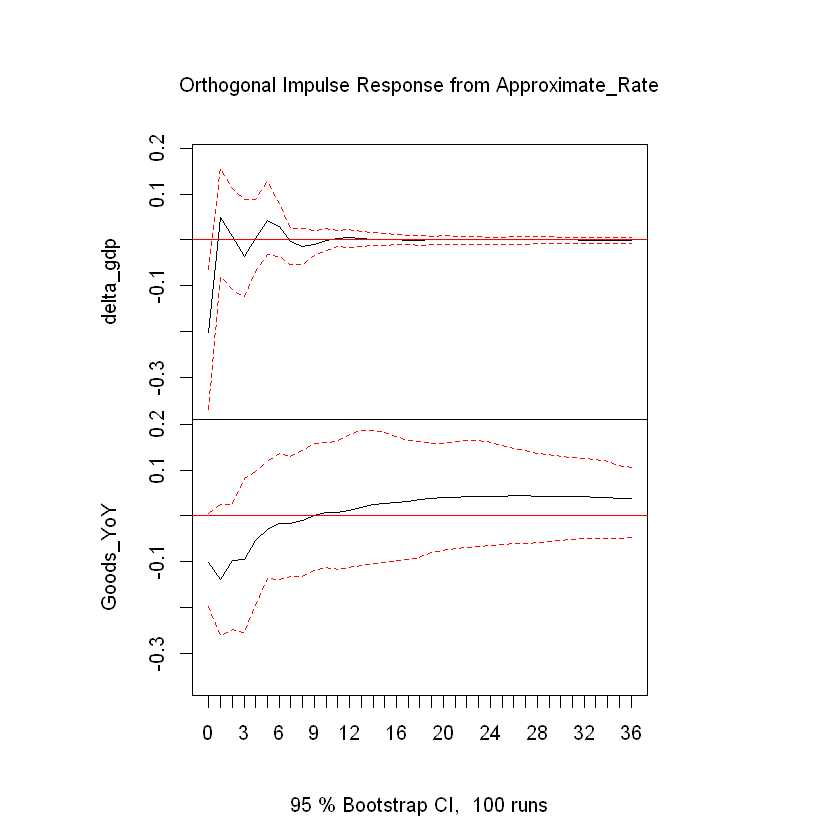

In [ ]:
# Generate the IRFs for a shock to the first variable in our order ('delta_trade_unc')
svar_irf <- irf(
  var_model_svar,
  impulse = "Approximate_Rate",  # The source of the shock
  response = c("Goods_YoY", "delta_gdp"), # The variables that respond
  n.ahead = 36,                 # How many months ahead to forecast
  boot = TRUE,                  # Generate bootstrap confidence intervals
  ci = 0.95                     # 95% confidence interval
)

# Plot the results
plot(svar_irf)